In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import emd
from statistics import mean
from scipy import signal, ndimage
import math

In [2]:
from scipy.optimize import curve_fit
import matplotlib.patches as ptc
from numpy.polynomial import Polynomial
from astropy.io import fits
from scipy.io import readsav
import os
import scipy.linalg as la
from scipy.stats import sem
from scipy import asarray as ar,exp

In [3]:
import scienceplots
plt.style.use(['science','notebook','grid'])

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
datContent = [i.strip().split() for i in 
              open("12_0134521701/mos_b50_12_0134521701_decay.dat").readlines()]

datContent = datContent[5:]

t= np.array(datContent)[:,0]
x1= np.array(datContent)[:,1]
e= np.array(datContent)[:,2]

In [6]:
t_,x_,e_=[],[],[]
for i in range(len(t)):
    t_.append(float(t[i]))
    x_.append(float(x1[i]))    
    e_.append(float(e[i]))    
    
t_ = np.array(t_)
x_ = np.array(x_)
e_ = np.array(e_)

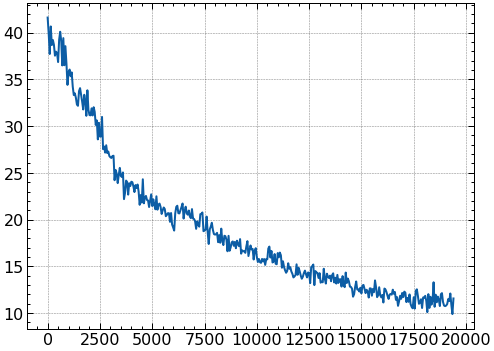

In [7]:

plt.plot(t_[:],x_[:])

In [8]:
dt= 50/60
fs= 1/dt

In [9]:
x=x_[:-2]
t1=t_[:-2]

In [10]:
t1=t1/60

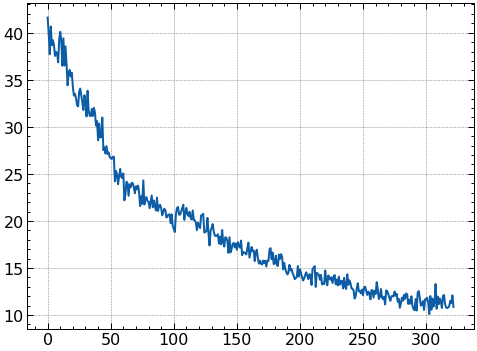

In [11]:
plt.plot(t1,x)

In [12]:
imfm = emd.sift.mask_sift(x)
n_imfm= len(imfm[0,:])

 Inputs samples (387) is small for specified max_imfs (9) very likely that 7 or fewer imfs are returned


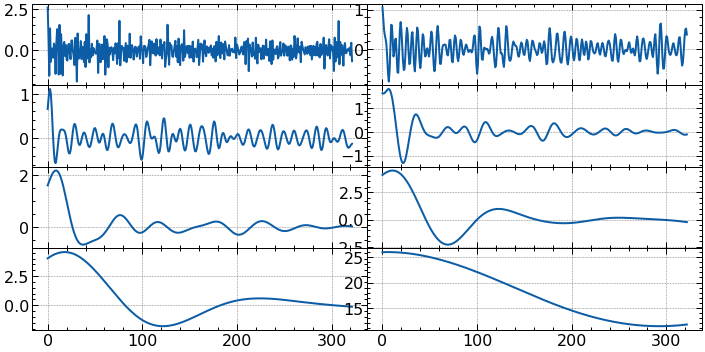

In [13]:
plt.figure(figsize=(12,12))

for i in range(n_imfm):
    plt.subplot(n_imfm,2,i +1)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.plot(t1,imfm[:,i])


In [14]:
trend=int(input('enter bg : '))

enter bg :  5


Text(0.5, 1.0, 'background trend')

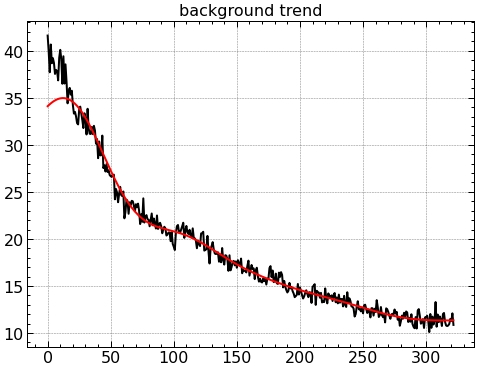

In [15]:
plt.plot(t1,x,c='black')
bg=np.zeros(len(imfm[:,0]))

for i in range(trend,n_imfm):
    bg=bg+imfm[:,i]
plt.plot(t1,bg,c='red')
plt.title('background trend')


Text(0.5, 1.0, 'trend removed')

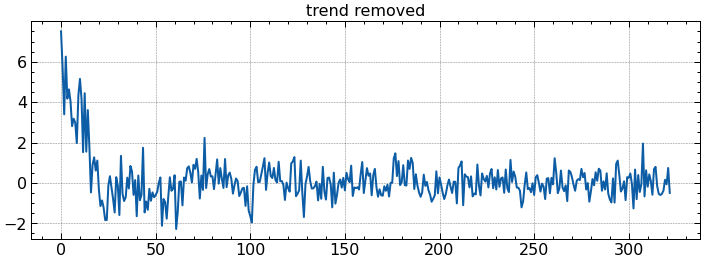

In [16]:
plt.figure(figsize=(12,4))
plt.plot(t1,x-bg)
plt.title('trend removed')

In [17]:
def bm(List):
    mins=[]
    maxs=[]
    for n, i in enumerate(List[1:-1]):
            if List[n] < List[n-1] and List[n] < List[n+1]:
                mins.append(List[n])
            elif List[n] > List[n-1] and i> List[n+1]:
                maxs.append(List[n])
    return len(mins)+len(maxs)

In [18]:
Em=[]
Pm=[]
for i in range(trend):
    E=mean(imfm[:,i]**2)
    P=len(imfm[:,i])/bm(imfm[:,i])
    Em.append(E)
    Pm.append(P)
    
Ex=mean(x**2)
Px=2*len(x)/bm(x)

Em=np.array(Em)
Pm=np.array(Pm)

(0.05, 18.113243848505785)

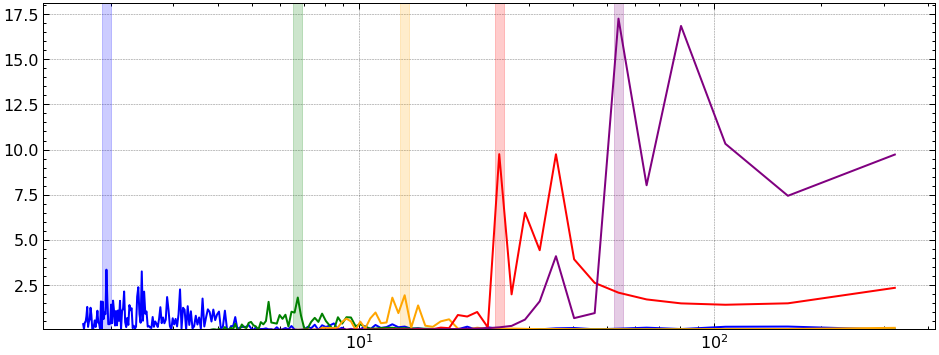

In [19]:
plt.figure(figsize = (16, 6))
col=['blue','green','orange','red','purple','violet','brown','pink']

Pp=[]
for i in range(trend):
    fxx, pxx =sp.signal.welch(imfm[:,i],fs,detrend='linear',window='boxcar',nperseg=len(imfm[:,i]))
    plt.plot(1/fxx,pxx,c=col[i%trend])
    Pp.append(1/fxx[np.where(pxx==max(pxx))])
    plt.axvspan(Pp[-1]*97/100,Pp[-1]*103/100,color=col[i%trend],alpha=.2)
    
plt.semilogx()
plt.ylim(.05)
# plt.xlim(0,1e2)




In [20]:
4.6 +np.log(len(fxx))

9.867858159063328

In [21]:
len(x-bg)

387

[]

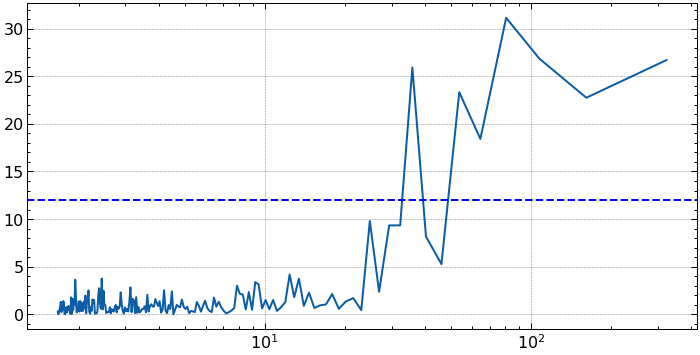

In [22]:
plt.figure(figsize = (12, 6))


fxx, pxx =sp.signal.welch(x-bg,fs,detrend='linear',window='boxcar', nperseg=1000)
plt.plot(1/fxx,pxx)

# mean_plus_std = np.mean(pxx) + 2*np.std(pxx)
# plt.axhline(y=mean_plus_std, color='green', linestyle='--')
# plt.axhline(y=4.6 +np.log(len(fxx)),color='blue', linestyle='--')

p0=0.4
plt.axhline(y=-np.log(1-(1-p0)**(1/len(fxx)))*mean(pxx),color='blue', linestyle='--')

plt.semilogx()
# plt.loglog()


In [23]:
mean(pxx)

2.0135849006108844

In [24]:
def log_fit(xi,yi,x,deg,col='green'):  
    coefficients = np.polyfit(np.log10(xi), np.log10(yi), deg)
    polynomial = np.poly1d(coefficients)
    log10_y_fit = polynomial(np.log10(x))  # <-- Changed

    L=[]
    L.append(x)
    L.append(10**log10_y_fit)
    return L

In [25]:
def fit(xi,yi,x,deg,col='green'):  
    coefficients = np.polyfit((xi), (yi), deg)
    polynomial = np.poly1d(coefficients)
    log10_y_fit = polynomial((x))  # <-- Changed

    L=[]
    L.append(x)
    L.append(log10_y_fit)
    return L

In [26]:
def spread(x,k,N):
    return x+(k*(math.sqrt(2/N))*(np.e**(x/2))),x-(k*(math.sqrt(2/N))*(np.e**(x/2)))

In [51]:
def bypart(xi,yi,s,e) : 
    lf= log_fit(xi[s:e],yi[s:e],np.linspace(xi[s],xi[e-1]+20,len(x)),1)
    slope= (lf[1][1]-lf[1][0])/(lf[0][1]-lf[0][0])
    print(slope)

    plt.title('Least square fit')
    plt.plot(lf[0],lf[1],'--',color='black',linewidth=1)
    U,L=[],[]
    
    for i in range(len(lf[0])):
        u,l=spread(lf[1][i],0.267,len(lf[1]))
        L.append((l))
        U.append((u))
    
    # for in range(len(Pm)):
    #     u1,l1=spread(Pm[i]/2,0.567,len(lf[1]))
    #     if u1>=
    
    plt.plot((lf[0])[:],U[:],c='black',linestyle='--')
    plt.plot((lf[0])[:],L[:],c='black',linestyle='--')
    
    plt.scatter((xi),(yi),color='blue',s=80)
    # plt.scatter((Px/2),(Ex),color='green')

    plt.loglog()
    # plt.scatter(Pm[-2],Em[-2],marker='d',s=180,c='red')
    # plt.scatter(Pm[-1],Em[-1],marker='d',s=180,c='red')
    plt.ylim(1e-3)


-0.11872211199893712


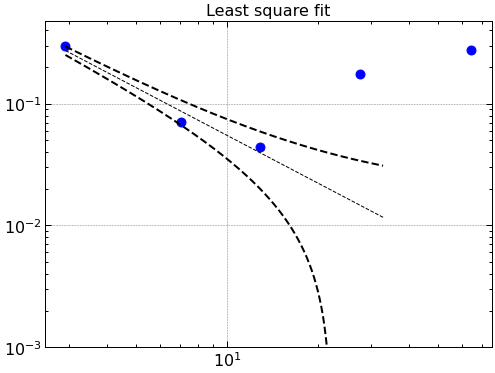

In [52]:
bypart(Pm,Em,0,3)
# bypart(Pm,Em,2,trend)

3.264911564932337 | 0.1351922860212368
6.338696306377225 | 0.04881108692096533
11.629501197028562 | 0.03065219551735606
29.822225491504504 | 0.021516255006338424
66.3130149161956 | 0.009675605211113434


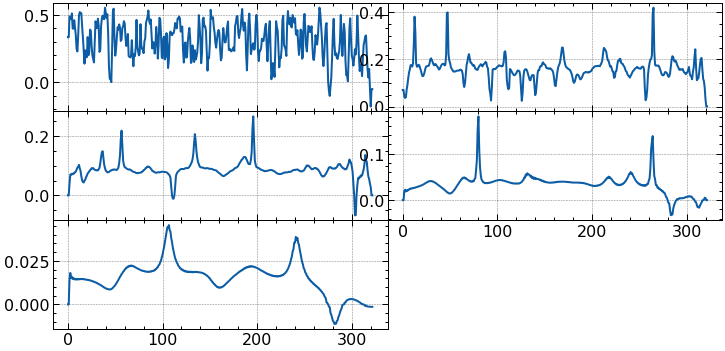

In [29]:
plt.figure(figsize=(12,16))
IP, IF, IA = emd.spectra.frequency_transform(imfm[:,:trend], fs, 'hilbert')
IPe=[]
IPe_std=[]
for i in range(trend):
    plt.subplot(n_imfm,2,i +1)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.plot(t1,IF[:,i])
    IPe.append(1/mean(IF[:,i]))
    IPe_std.append(np.std(IF[:,i]))
    print(1/mean(IF[:,i]),'|',np.std(IF[:,i]))
    
    # plt.semilogy()

In [30]:
# plt.scatter(IPe,IPe_std,marker='d',s=200,color='blue')
# plt.loglog()

In [31]:

# plt.scatter(Pp,Pm/2,c='green',s=100,marker='d')

# plt.scatter(Pp,IPe,c='red',s=100,marker='d')
# plt.legend(['from instantaneous frequency','from Sigal extrema'])
# plt.xlabel('from Zero crossings (period)')
# plt.ylabel('(period)')
# plt.grid(False)

In [32]:
def ds(t,A,P,tau,phi,t0):
        return A*exp(-(t-t0)/tau)*np.sin(2*np.pi*(t-t0)/P -phi)

In [33]:
def scaling(t,c,m):
    return c*(t**m)

[0.56274743 0.72737499]


[]

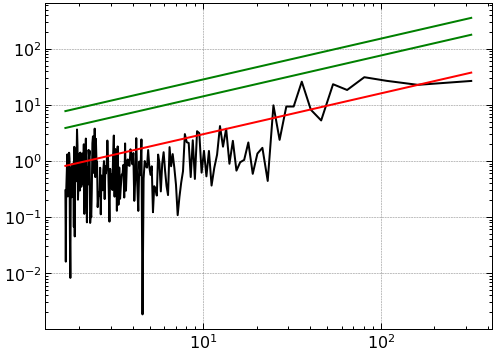

In [34]:
non_zero_indices = fxx != 0
period = 1 / fxx[non_zero_indices]

fxx, pxx =sp.signal.welch(x-bg,fs,detrend='linear',window='boxcar', nperseg=len(x-bg))
popt, pcov = curve_fit(scaling,period, pxx[non_zero_indices])
print(popt)

sig=np.std(pxx)
prd=np.linspace(min(period),max(period),1000)

plt.plot(period,pxx[non_zero_indices],c='black')
plt.plot(prd, scaling(prd, *popt), color='red')
# plt.plot(prd, scaling(prd, *popt)*((2*sig)), color='red')
plt.plot(prd, scaling(prd, *popt)*((1*sig)), color='green')
plt.plot(prd, scaling(prd, *popt)*((2*sig)), color='green')

# plt.axvline(x=P,c='red')
# plt.ylim(1e-2)
plt.loglog()
# plt.semilogx()

In [35]:
HS=[4,7]

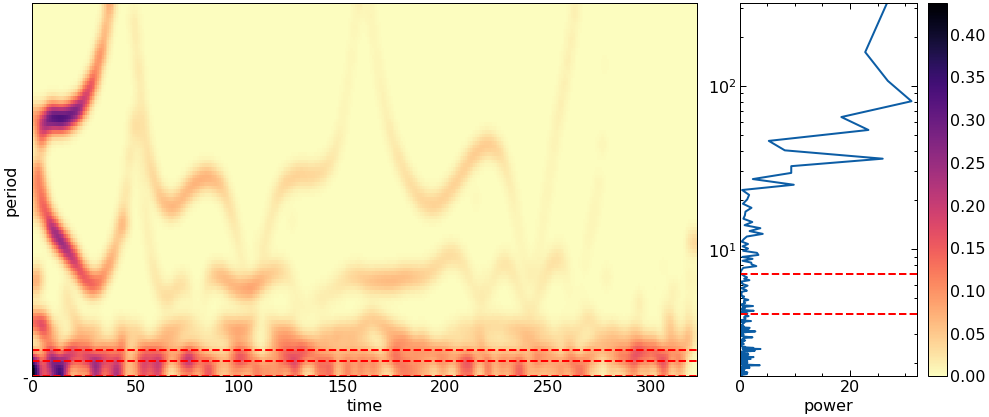

In [44]:

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]},figsize=(14,6))

i=trend

IP, IF, IA = emd.spectra.frequency_transform(imfm[:,:trend], fs, 'hilbert')
freq_range = (0, 100, 100)
hht_f, hht = emd.spectra.hilberthuang(1/IF[:,:i], IA[:,:i], freq_range, mode='amplitude', sum_time=False)
hht = ndimage.gaussian_filter(hht, 2.5)
c=a0.pcolormesh(t1, hht_f, hht, cmap='magma_r')

for i in HS:
    a0.axhline(y=i,linestyle='--',c='red')

a0.set_ylabel('period')
a0.set_xlabel('time')
plt.colorbar(c)





fxx, pxx =sp.signal.welch(x-bg,fs,detrend='linear',window='boxcar', nperseg=len(x-bg))
a1.plot(pxx,1/fxx)
a1.set_xlabel('power')
# a1.axhspan(IPe[-1],Pp[-1],linestyle='--',alpha=.6,color='lightblue')
a1.grid(False)


fxx, pxx =sp.signal.welch(x-bg,fs,detrend='linear',window='boxcar', nperseg=len(x-bg))
# popt, pcov = curve_fit(scaling,period, pxx[non_zero_indices])
# pwl=scaling(prd, *popt)*((1*sig))
# plt.plot(pwl, prd,color='red',linestyle='--')
for i in HS:
    a1.axhline(y=i,linestyle='--',c='red')
a1.set_ylim(min(prd),max(prd))
a1.set_xlim(0,max(pxx)+1)
a1.semilogy()



plt.tight_layout()

In [37]:
# n=int(input('enter IMF number'))

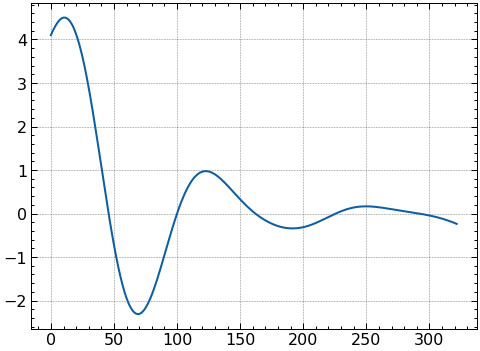

In [48]:

qpp= imfm[:,5]
tf=t1[:]
plt.plot(tf,qpp)


period:   115.09 ;  damping time:   72.72



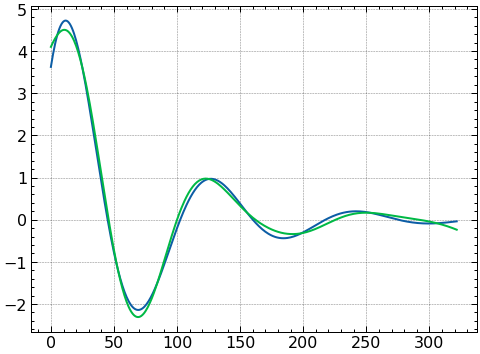

In [49]:
popt, pcov = curve_fit(ds,tf, qpp,bounds=(0,[1e3,1e3,1e3,1e3,1e3] ))
Ads,Pds,tau,phi,t0= popt


plt.plot(tf, ds(tf, *popt))
plt.plot(tf,qpp)
print()
print('period:  ',Pds.round(2),'; ','damping time:  ',tau.round(2))
print()

[]

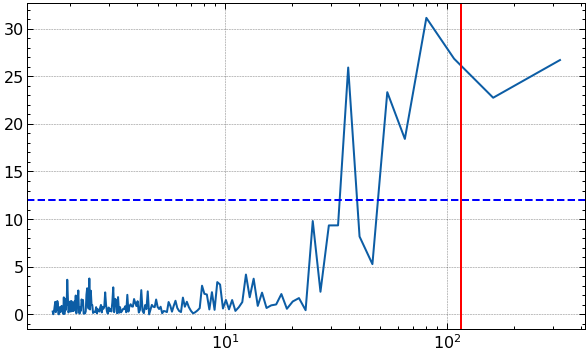

In [50]:
plt.figure(figsize=(10,6))

fxx, pxx =sp.signal.welch(x-bg,fs,detrend='linear',window='boxcar', nperseg=1000)
plt.plot(1/fxx,pxx)
p0=.4
plt.axhline(y=-np.log(1-(1-p0)**(1/len(fxx)))*mean(pxx),color='blue', linestyle='--')
plt.axvline(x=Pds,c='red',linestyle='-')

plt.semilogx()
# plt.ylim(0,2)

In [41]:
for a in range(len(Pp)):
    Pp[a]=Pp[a][0]

In [42]:
HS=['-',4,7]

In [43]:
print('Pp'," "*(7-len('Pp')),'|',
       'IF'," "*(7-len('IF')),'|',
       'Pm'," "*(7-len('IF')),'|',
       'HS')
print('-'*36)

for a in range(trend):
    if isinstance(Pp[a],float):
        Pp[a]=Pp[a].round(2)
    if isinstance(Pm[a],float):
        Pm[a]=Pm[a].round(2)
    if isinstance(IPe[a],float):
        IPe[a]=IPe[a].round(2)


for a in range(trend):
    if a>=trend:
        print('-'," "*(7-len('-')),'|',
              '-'," "*(7-len('-')),'|',
              '-'," "*(7-len('-')),'|',
              HS[a])
    

    else:
        print(Pp[a]," "*(7-len(str(Pp[a]))),'|',
              IPe[a]," "*(7-len(str(IPe[a]))),'|',
              Pm[a]," "*(7-len(str(Pm[a]))),'|',
              HS[a])

Pp       | IF       | Pm       | HS
------------------------------------
1.94     | 3.26     | 2.91     | -
6.72     | 6.34     | 7.04     | 4
13.44    | 11.63    | 12.9     | 7


IndexError: list index out of range

In [ ]:
a

In [ ]:
HS

In [ ]:
table={}
table['Pp']=Pp
table['IF']=IPe
table['Pm']=Pm

### 